In [1]:
from itertools import chain
import scipy
from scipy.optimize import fmin
from scipy.stats import norm
from scipy.stats import beta
from scipy.special import gamma as gammaf
import numpy as np
import random
import time
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [36]:
def get_parts(length, number_of_chunks):
    cuts = set()
    while len(cuts) < number_of_chunks - 1:
        cuts.add(random.randint(1, length - 1))
    cuts = [0] + list(sorted(cuts)) + [length]
    return [cuts[i + 1] - cuts[i] for i in range(len(cuts) - 1)]

def print_parts(parts):
    print('|' + '|'.join(''.join(random.sample('ATCG' * i, i)) for i in parts) + '|')
    
def show_plot(parts):
    # https://matplotlib.org/gallery/lines_bars_and_markers/simple_plot.html
    # Data for plotting
    t = sorted(set(parts))
    s = [parts.count(i) for i in t]

    fig, ax = plt.subplots()
    ax.plot(t, s)
    ax.set(xlabel='Chunk size', ylabel='Number of occurences',
           title='%s nucleotide long chain divided into %s chunks' % (sum(parts), len(parts)))
    ax.grid()

    fig.savefig("test.png")
    plt.show()

def show_hist(parts):
    # Data for plotting
    t = sorted(set(parts))
    s = [parts.count(i) for i in t]

    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(s, density=10)

    ax.set(xlabel='Chunk size', ylabel='Number of occurences',
           title='%s nucleotide long chain divided into %s chunks' % (sum(parts), len(parts)))
    ax.grid()

    plt.show()

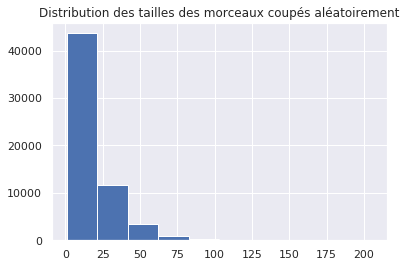

In [37]:
"""show_plot(get_parts(1000000, 60000))
show_hist(get_parts(1000000, 60000))

# print_parts(get_parts(100, 10))
def main():
    # Data for plotting

    fig, ax = plt.subplots()
    for i in range(6):
        print('Loading %s...' % i)
        parts = get_parts(10 ** i, (10 ** i) / 2)
        T = time.time()
        t = sorted(set(parts))
        s = [parts.count(i) for i in t]
        s = [i / max(s) for i in s]

        ax.plot(t, s)
        ax.set(xlabel='Chunk size', ylabel='Number of occurences',
               title='%s nucleotide long chain divided into %s chunks' % (sum(parts), len(parts)))
        ax.grid()

        plt.savefig("plot-%s.png" % i)
        print('Loading %s...done in %s' % (i, time.time() - T))

    plt.show()"""
a=1
b=60000

#x= np.linspace(0,1)
taille = get_parts(1000000, 60000)
plt.hist(taille)
plt.title("Distribution des tailles des morceaux coupés aléatoirement")
plt.show()


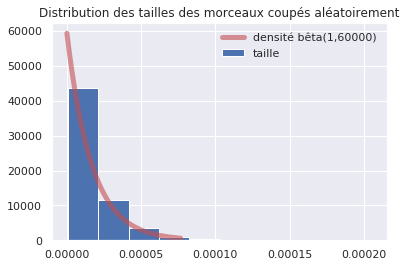

In [38]:
t = sum(taille)
norm = [i / t for i in taille]
#weights = np.ones_like(taille) / float(len(taille))
rv = beta(1, 60000)
x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 60000)
plt.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6, label='densité bêta(1,60000)')
plt.hist(norm,label='taille')
plt.legend(loc='best', frameon=False)
plt.title("Distribution des tailles des morceaux coupés aléatoirement")
plt.show()




In [44]:
def betaNLL(param, *args):
    """
    Negative log likelihood function for beta
    <param>: list for parameters to be fitted.
    <args>: 1-element array containing the sample data.
    Return <nll>: negative log-likelihood to be minimized.
    """

    
    a, b = param
    data = args[0]
    pdf = beta.pdf(data,a,b,loc=0,scale=1)
    lg = np.log(pdf)
    #mask = np.isnan(lg)
    nll = -1*np.sum(lg)
    return nll

#----------------Normalize to [0,1]----------------
t = sum(taille)
taille = [i / t for i in taille]

mean = np.mean(taille)
print(mean)
var = np.var(taille, ddof=1)
print(var)
alpha1 = mean ** 2 * (1 - mean) / var - mean
print(alpha1)
beta1 = alpha1 * (1 - mean) / mean
print(beta1)


1.666666666666912e-05
2.6265469980062953e-10
1.0575435001952862
63451.552468207636


In [43]:
result = fmin(betaNLL, [1, 1], args=(taille,))
alpha2, beta2 = result
print(alpha2)
print(beta2)



Optimization terminated successfully.
         Current function value: -600595.596871
         Iterations: 125
         Function evaluations: 257
1.1752289930435111
70512.1437318023


In [41]:
alpha3, beta3, xx, yy = beta.fit(taille)
print(alpha3)
print(beta3)

1.7292930108581608
40843787808508.91


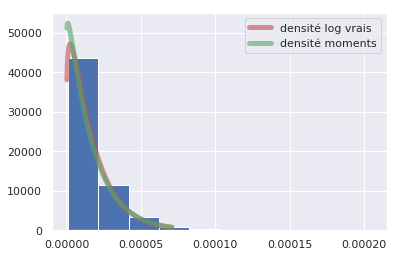

In [42]:

weights = np.ones_like(taille) / float(len(taille))

#plt.hist(taille, weights=weights)
fitted = lambda x, a, b: gammaf(a + b) / gammaf(a) / gammaf(b) * x ** (a - 1) * (1 - x) ** (b - 1)  # pdf of beta

xx = np.linspace(beta.ppf(0.01, alpha2, beta2), beta.ppf(0.99, alpha2, beta2), 60000)
plt.plot(xx, beta.pdf(xx, alpha2, beta2),'r-', lw=5, alpha=0.6, label='densité log vrais')
plt.plot(xx, beta.pdf(xx, alpha1, beta1),'g-', lw=5, alpha=0.6, label='densité moments')
plt.legend()
#plt.plot(xx, beta.pdf(xx, alpha3, beta3), lw=5, alpha=0.6, label='densité bêta(1,60000)')
#plt.plot(xx, fitted(xx, alpha1, beta1), 'g')
#plt.plot(xx, fitted(xx, alpha2, beta2), 'b')
#plt.plot(xx, fitted(xx, alpha3, beta3), 'r')


plt.hist(taille)

plt.show()

In [45]:
def frac(taille_échantillon, nombre_fragments):
    # On prends chaque échantillon et lui associe un nombre de fractures, converti en int à la volée
    échantillons_fracturés = []
    if nombre_fragments > taille_échantillon:
        raise ValueError(
            '\n\n\n'
            'ERREUR: Le nombre de fragments demandé est trop grand, il est impossible de continuer\n'
            'Vous pouvez: \n'
            '\t- Réduire le nombre de fragments demandé, en jouant sur N \n'
            '\t- Augmenter la taille des échantillons à fracturer\n'
    )
    # Il y aura n - 1 fractures pour obtenir n elements
    nombre_fractures = nombre_fragments - 1

    # Une fracture sera placée avant l'index désigné, donc une fracture
    #   localisée à l'index 1 donnera un morceau de 1 et un de taille - 1
    fractures = set()
    while len(fractures) < nombre_fractures:
        fractures.update(np.random.randint(1, taille_échantillon - 1, nombre_fractures))
    if len(fractures) != nombre_fractures:
        if len(fractures) < nombre_fractures:
            raise RuntimeError('ERREUR: Une erreur s\'est produite: pas assez de fragments')
        fractures = set(list(fractures)[:nombre_fractures])
    fractures = [0] + list(sorted(fractures)) + [taille_échantillon]
    échantillon_fracturé = [
        fractures[i + 1] - fractures[i] for i in range(len(fractures) - 1)
    ]
    if sum(échantillon_fracturé) != taille_échantillon:
        raise RuntimeError(
            "ERREUR: Une erreur s'est produite lors de la fragmentation, \n"
            f"Nous avons {abs(sum(échantillon_fracturé) - taille_échantillon)}"
            f" fragments de différence entre ce qu'on attendais et ce qu'on a"
            f" ({sum(échantillon_fracturé)} contre {taille_échantillon})"
        )
    échantillon_fracturé = list(i for i in sorted(échantillon_fracturé))
    échantillons_fracturés.append(échantillon_fracturé)

    return échantillons_fracturés


(0.9530817819251425, 72.09083653714931, 1.9999999999999998, 117942.45961480087)


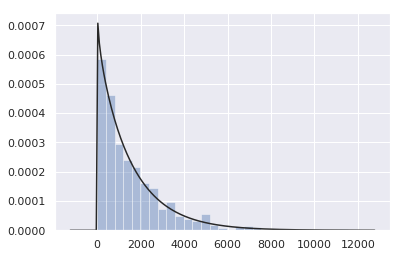

In [46]:
g = 1000000
n = 650
taille = frac(g,n)
sns.distplot(taille, kde=False, fit=beta)
print(beta.fit(taille))

In [47]:
lois = ['normale', 'uniforme', 'poisson']

def fracture(echantillons, n=65952, sigma=100, loi='normale'):
    """
    Fracture une liste d'échantillons en utilisant un nombre de fractures variables de loi n = Norm(N, sigma)
    :param sigma:
    :param n: Ecart-type
    :param echantillons:
    :return:
    """
    #
    échantillons_fracturés = []
    
    n = dict(
        normale = n + np.random.randn(len(echantillons)) * sigma,
        uniforme = np.random.uniform(0, 131206, len(echantillons)),
        poisson = np.random.poisson(65603, len(echantillons)), #erreur
        géométrique = np.random.geometric(1./65603, len(echantillons)),#erreur
        exponentielle = np.random.exponential(1./65603, len(echantillons)) 
    )[loi]

    for i in range(len(echantillons)):
        n[i]=n[i]/len(echantillons)
    
    # On prends chaque échantillon et lui associe un nombre de fractures, converti en int à la volée
    for index, (nombre_fragments, taille_échantillon) in enumerate(zip(map(int, n), echantillons)):

        if nombre_fragments > taille_échantillon:
            raise ValueError(
                '\n\n\n'
                'ERREUR: Le nombre de fragments demandé est trop grand, il est impossible de continuer\n'
                'Vous pouvez: \n'
                '\t- Réduire le nombre de fragments demandé, en jouant sur N et sigma\n'
                '\t- Augmenter la taille des échantillons à fracturer\n'
            )
        # Il y aura n - 1 fractures pour obtenir n elements
        nombre_fractures = nombre_fragments - 1

        # Une fracture sera placée avant l'index désigné, donc une fracture
        #   localisée à l'index 1 donnera un morceau de 1 et un de taille - 1
        fractures = set()
        while len(fractures) < nombre_fractures:
            fractures.update(np.random.randint(1, taille_échantillon - 1, nombre_fractures))
        if len(fractures) != nombre_fractures:
            if len(fractures) < nombre_fractures:
                raise RuntimeError('ERREUR: Une erreur s\'est produite: pas assez de fragments')
            fractures = set(list(fractures)[:nombre_fractures])
        fractures = [0] + list(sorted(fractures)) + [taille_échantillon]
        échantillon_fracturé = [
            fractures[i + 1] - fractures[i] for i in range(len(fractures) - 1)
        ]
        if sum(échantillon_fracturé) != taille_échantillon:
            raise RuntimeError(
                "ERREUR: Une erreur s'est produite lors de la fragmentation, \n"
                f"Nous avons {abs(sum(échantillon_fracturé) - taille_échantillon)}"
                f" fragments de différence entre ce qu'on attendais et ce qu'on a"
                f" ({sum(échantillon_fracturé)} contre {taille_échantillon})"
            )
        échantillon_fracturé = list(i for i in sorted(échantillon_fracturé))
        échantillons_fracturés.append(échantillon_fracturé)

    return échantillons_fracturés


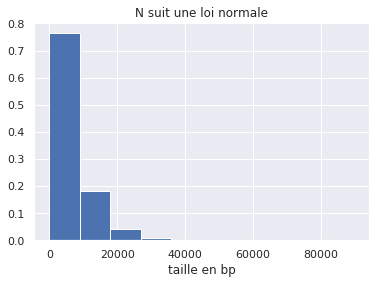

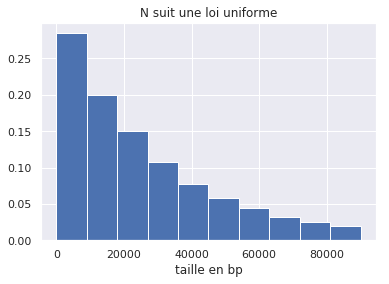

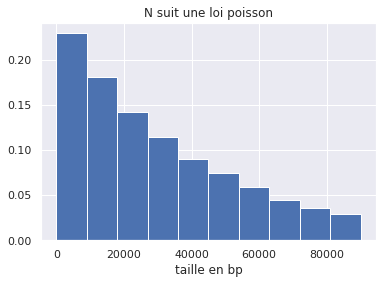

In [48]:
sns.set(color_codes=True)
# sns.distplot(fragments, kde=False, rug=False)
# plt.show()

taille_genome = 2543000
nombre_morceaux = 409995
seuil = 90000

for loi in lois:
    fragments = list(chain.from_iterable(fracture([taille_genome] * 1000, nombre_morceaux, loi=loi)))
    fragments = [x for x in fragments if x < seuil] 
    weights = np.ones_like(fragments) / float(len(fragments))
    plt.xlabel('taille en bp')
    plt.title('N suit une loi %s' %loi)
    plt.hist(fragments, bins=10, weights=weights)
    plt.show()

